In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from matplotlib_venn import venn3

import sys
sys.path.append('../mchem_functions/')
import multivariate_functions as mvf

In [32]:
predictand_a = np.array([
[1, 0, 0, 0, 0, 0,],
[0, 0, 0, 0, 0, 0,],
[0, 1, 0, 0, 0, 0,],
[11, 4, 0, 0, 8, 1,],
[11, 5, 17, 7, 0, 0,],
[9, 6, 0, 0, 6, 2,],
[9, 7, 13, 10, 0, 0,],
[7, 8, 0, 0, 4, 3,],
[7, 9, 10, 13, 0, 0,],
[5, 10, 0, 0, 2, 4,],
])

predictor_a = np.array([
[1,  0, 1, 0],
[2,  0, 1, 0],
[3,  0, 1, 0],
[4,  0, 0, 1],
[5,  1, 0, 0],
[6,  0, 0, 1],
[7,  1, 0, 0],
[8,  0, 0, 1],
[9,  1, 0, 0],
[10, 0, 0, 1],
])

predictand_b = np.array([
[4.615, 10.003, 0.307, 0.184, 0.274],
[5.226, 9.999, 0.207, 0.212, 0.213],
[5.081, 9.636, 0.140, 0.229, 0.134],
[5.278, 8.331, 1.371, 0.287, 0.177],
[5.756, 8.929, 1.447, 0.242, 0.091],
[5.328, 8.839, 0.668, 0.531, 0.272],
[4.263, 7.784, 0.300, 0.948, 0.460],
[5.442, 8.023, 0.329, 1.389, 0.253],
[5.328, 8.294, 0.207, 0.765, 0.235],
[4.663, 7.883, 0.223, 0.737, 0.362],
[6.775, 9.741, 0.788, 0.454, 0.824],
[5.442, 8.657, 1.112, 0.395, 0.419],
[5.421, 8.117, 1.273, 0.247, 0.398],
[5.602, 8.117, 0.956, 0.449, 0.172],
[5.442, 8.487, 0.708, 0.457, 0.141],
[5.303, 7.955, 0.637, 0.386, 0.360],
[5.602, 10.545, 0.519, 0.481, 0.261],
[5.505, 9.687, 0.247, 0.468, 0.450],
[6.019, 8.700, 1.664, 0.321, 0.287],
[5.464, 10.240, 0.182, 0.380, 0.510],
])

predictor_b = np.array([
[-8.75, 3.7, 76.5625],
[-6.75, 2.7, 45.5625],
[-5.75, 1.7, 33.0625],
[-5.75, 3.7, 33.0625],
[-3.75, 2.7, 14.0625],
[-2.75, 3.7, 7.5625],
[-1.75, 0.7, 3.0625],
[-0.75, -0.3, 0.5625],
[0.25, -1.3, 0.0625],
[0.25, 0.7, 0.0625],
[0.25, 2.7, 0.0625],
[1.25, 1.7, 1.5625],
[3.25, -4.3, 10.5625],
[3.25, -2.3, 10.5625],
[3.25, -1.3, 10.5625],
[4.25, -5.3, 18.0625],
[4.25, -4.3, 18.0625],
[4.25, -2.3, 18.0625],
[5.25, -0.3, 27.5625],
[6.25, -2.3, 39.0625],
])

Y = predictand_a
X = predictor_a

# Y = np.divide(np.subtract(Y,np.mean(Y,axis=0)) , np.std(Y,axis=0))
# X = np.subtract(X,np.mean(X,axis=0))#np.divide(np.subtract(X,np.mean(X,axis=0)) , np.std(X,axis=0))

In [33]:
(eigvals_can, proportion_explained_can, U_can, Z_can, eigvals_noncan,
 proportion_explained_noncan, U_noncan, Z_noncan, R2_partial, R2_a, r_k,
 R_XZ, BS_1, F_statistic, crit_F_value, p_value) = mvf.RDA(Y,X)

The null-hypothesis is False in the 95.0% confidence range (F-statistic = 29.78, critical F value = 5.19).
p = 0.001


# pRDA to work on

In [34]:
def pRDA(Y:np.ndarray,X:np.ndarray,W:np.ndarray,confidence:float=0.95,verbose:bool=True):

    n, p = np.shape(Y)
    m = np.shape(X)[1]
    
    Y_c = Y - np.mean(Y,axis=0)
    X_c = X - np.mean(X,axis=0)
    W_c = W - np.mean(W,axis=0)

    Y_hatW = mvf.OLS(Y_c,W_c)
    X_hatW = mvf.OLS(X_c,W_c)

    Y_resW = Y_c - Y_hatW
    X_resW = X_c - X_hatW

    (eigvals_can, proportion_explained_can, U_can, Z_can, eigvals_noncan,
     proportion_explained_noncan, U_noncan, Z_noncan, R2_partial, R2_a, r_k,
     R_XZ, BS_1, F_statistic, crit_F_value, p_value) = mvf.RDA(Y_resW,X_resW,
                                                           confidence=confidence,
                                                           verbose=verbose)

    R2_semipartial = mvf.RDA(Y_c,X_resW,confidence=confidence,verbose=verbose)[-8]



    return R2_partial, R2_semipartial

In [35]:
Y = predictand_a
W, X = predictor_a[:,0,None], predictor_a[:,1:]

In [36]:
predictand_a = np.array([
[1, 0, 0, 0, 0, 0,],
[0, 0, 0, 0, 0, 0,],
[0, 1, 0, 0, 0, 0,],
[11, 4, 0, 0, 8, 1,],
[11, 5, 17, 7, 0, 0,],
[9, 6, 0, 0, 6, 2,],
[9, 7, 13, 10, 0, 0,],
[7, 8, 0, 0, 4, 3,],
[7, 9, 10, 13, 0, 0,],
[5, 10, 0, 0, 2, 4,],
])

predictor_a = np.array([
[1,  0, 1, 0],
[2,  0, 1, 0],
[3,  0, 1, 0],
[4,  0, 0, 1],
[5,  1, 0, 0],
[6,  0, 0, 1],
[7,  1, 0, 0],
[8,  0, 0, 1],
[9,  1, 0, 0],
[10, 0, 0, 1],
])

# Variation Partitioning!!!

In [37]:
Y = pd.read_csv('https://raw.githubusercontent.com/JoeyBernhardt/NumericalEcology/refs/heads/master/DoubsSpe.csv',index_col='Unnamed: 0').drop(index=8).to_numpy()
X = pd.read_csv('https://raw.githubusercontent.com/JoeyBernhardt/NumericalEcology/refs/heads/master/DoubsEnv.csv',index_col='Unnamed: 0').drop(index=8)

In [38]:
topography_df = X[['alt','pen','deb']]
# chemistry_df = X[['pH','dur','pho','nit','amm','oxy','dbo']]
chemistry_df = X[['pH','dur','pho','nit','amm','oxy','dbo']]
geography_df = X[['das']]

topography = topography_df.to_numpy()
chemistry = chemistry_df.to_numpy()
geography = geography_df.to_numpy()

# Hellinger Transform Y
row_sum = np.sum(Y,axis=1)
row_sum = np.reshape(row_sum,(len(row_sum),1))
Y = np.sqrt(Y/row_sum)

# mvf.standardise Xs
topography = mvf.standardise(topography)
chemistry = mvf.standardise(chemistry)
geography = mvf.standardise(geography)



In [39]:
variables = [topography,chemistry,geography]
str_variables = ['Topography','Chemistry','Geography']

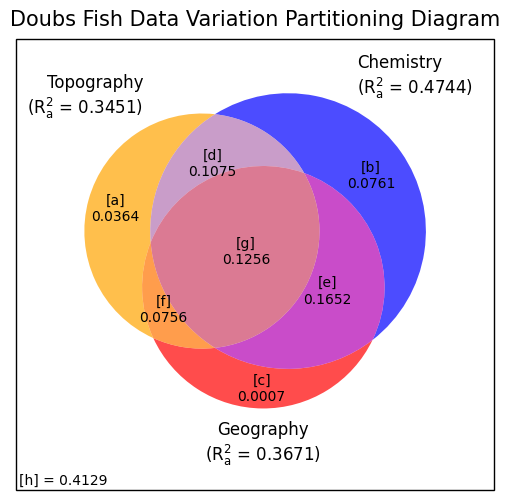

In [40]:
style = 'venn'
R2_list, venn_dict = mvf.varpart(Y,variables,X_labels=str_variables,title='Doubs Fish Data Variation Partitioning Diagram',save_path=f'./doubs_varpart_{style}.svg',diagram=style)

In [41]:
venn_dict

{('Topography',): 0.3451,
 ('Chemistry',): 0.4744,
 ('Geography',): 0.3671,
 ('Topography', 'Chemistry'): 0.5864,
 ('Topography', 'Geography'): 0.511,
 ('Chemistry', 'Geography'): 0.5507,
 ('Topography', 'Chemistry', 'Geography'): 0.5871}

In [42]:
venn_dict_legendre = {
    ('Topography',): .345,
    ('Chemistry',): .474,
    ('Geography',): .367,
    ('Topography', 'Chemistry'): .586,
    ('Topography', 'Geography'): .511,
    ('Chemistry', 'Geography'): .551,
    ('Topography', 'Chemistry', 'Geography'): .587
}

for key in venn_dict_legendre:
    print(f'% error for {key} = {np.round(100*((venn_dict[key]/venn_dict_legendre[key])-1),3)}%')

% error for ('Topography',) = 0.029%
% error for ('Chemistry',) = 0.084%
% error for ('Geography',) = 0.027%
% error for ('Topography', 'Chemistry') = 0.068%
% error for ('Topography', 'Geography') = 0.0%
% error for ('Chemistry', 'Geography') = -0.054%
% error for ('Topography', 'Chemistry', 'Geography') = 0.017%


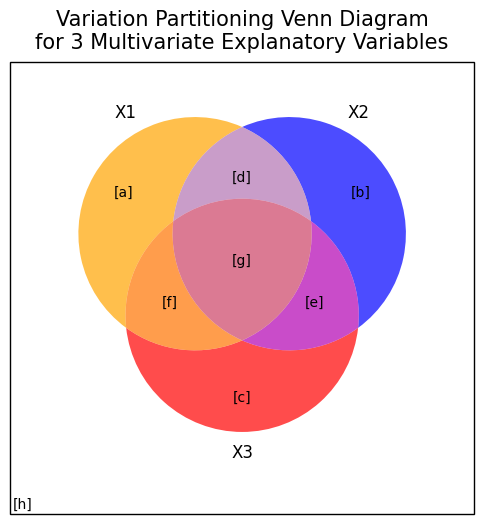

In [43]:
labels = ['X1','X2','X3']
v = venn3(subsets=[1]*7,set_labels=labels,set_colors=("orange", "blue", "red"), alpha=0.7)

subsets_str = ['a','b','c','d','e','f','g']
pos = ['100','010','001','110','011','101','111']

for i in range(len(pos)):
    v.get_label_by_id(pos[i]).set_text(f'[{subsets_str[i]}]')

fig = plt.gcf()
ax = plt.gca()

rect_coord = (np.min(ax.get_xlim())-.15,np.min(ax.get_ylim())-.2)
rect = plt.Rectangle(rect_coord,
                     width  = np.max(ax.get_xlim())-np.min(ax.get_xlim()) + 0.15*2,
                     height = np.max(ax.get_ylim())-np.min(ax.get_ylim()) + 0.3,
                     edgecolor='k',ls='-',lw=1,facecolor='none',clip_on=False)

ax.add_patch(rect)
ax.text(rect_coord[0]+0.01,rect_coord[1]+0.02,f'[h]')

ax.text(np.mean(plt.xlim()),np.max(plt.ylim())+.15,'Variation Partitioning Venn Diagram\nfor 3 Multivariate Explanatory Variables',fontsize=15,ha='center')
fig.savefig('example_venn.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

# Application of RDA to my Data

In [44]:
mv_expl_var_file = 'explanatory_variables.csv'
mv_expl_var_df = pd.read_csv(mv_expl_var_file)
samples_names_x = mv_expl_var_df['samples'].to_numpy()
samples_names_x = np.array([x.replace('-PW','') for x in samples_names_x])
aem_expl_var = mv_expl_var_df['AEM'].to_numpy()
dbmem_expl_var = mv_expl_var_df['dbMEM'].to_numpy()

## MS

In [45]:
ms_data_dir = '../../Data/MS_data/CSV_files/processed_csv_data_dir'
ms_data_file = 'overall_intensity_ordination_table.csv'
ms_df = pd.read_csv(f'{ms_data_dir}/{ms_data_file}',index_col=0)
ms_df = ms_df[ms_df['replicate_y/n']==0].drop('replicate_y/n',axis=1)
ms_df[ms_df.isna()] = 0
ms_df[ms_df > 0] = 1
samples_names_ms = np.array(ms_df.index)
hm_ms_names = np.array([x for x in samples_names_ms if 'HM' in x])
am_ms_names = np.array([x for x in samples_names_ms if 'AM' in x])

In [46]:
hm_ms_arr = ms_df.to_numpy()[np.where(np.isin(samples_names_ms,hm_ms_names))]
am_ms_arr = ms_df.to_numpy()[np.where(np.isin(samples_names_ms,am_ms_names))]

In [47]:
hm_aem_expl_var = aem_expl_var[np.where(np.isin(samples_names_x,hm_ms_names))]
hm_dbmem_expl_var = dbmem_expl_var[np.where(np.isin(samples_names_x,hm_ms_names))]
am_aem_expl_var = aem_expl_var[np.where(np.isin(samples_names_x,am_ms_names))]
am_dbmem_expl_var = dbmem_expl_var[np.where(np.isin(samples_names_x,am_ms_names))]

In [48]:
dbmem_expl_var_list = []
for line in dbmem_expl_var:
    dbmem_expl_var_list.append(np.array([x for x in line.replace('[','').replace(']','').replace('\n','').split(' ') if x != '']).astype(float))
max_len = np.max([len(x) for x in dbmem_expl_var_list])
# dbmem_expl_var_list = [np.append(x,[0]*(max_len-len(x))) for x in dbmem_expl_var_list]
# dbmem_expl_var = np.array(dbmem_expl_var_list)
aem_expl_var_list = []
for line in aem_expl_var:
    aem_expl_var_list.append(np.array([x for x in line.replace('[','').replace(']','').replace('\n','').split(' ') if x != '']).astype(float))
max_len = np.max([len(x) for x in aem_expl_var_list])

In [49]:
am_idx_x = [i for i in range(len(samples_names_x)) if samples_names_x[i] in am_ms_names]
hm_idx_x = [i for i in range(len(samples_names_x)) if samples_names_x[i] in hm_ms_names]
am_dbmem_expl_var_arr = np.array([dbmem_expl_var_list[idx] for idx in am_idx_x])
hm_dbmem_expl_var_arr = np.array([dbmem_expl_var_list[idx] for idx in hm_idx_x])
am_dbmem_expl_var_arr = np.array([dbmem_expl_var_list[idx] for idx in am_idx_x])
hm_dbmem_expl_var_arr = np.array([dbmem_expl_var_list[idx] for idx in hm_idx_x])
am_aem_expl_var_arr = np.array([aem_expl_var_list[idx] for idx in am_idx_x])
hm_aem_expl_var_arr = np.array([aem_expl_var_list[idx] for idx in hm_idx_x])
am_aem_expl_var_arr = np.array([aem_expl_var_list[idx] for idx in am_idx_x])
hm_aem_expl_var_arr = np.array([aem_expl_var_list[idx] for idx in hm_idx_x])

In [50]:
(eigvals_can, proportion_explained_can, U_can, Z_can, eigvals_noncan,
 proportion_explained_noncan, U_noncan, Z_noncan, R2_partial, R2_a, r_k,
 R_XZ, BS_1, F_statistic, crit_F_value, p_value) = mvf.RDA(hm_ms_arr,hm_dbmem_expl_var_arr)

The null-hypothesis is True in the 95.0% confidence range (F-statistic = 1.02, critical F value = 19.3).
p = 0.562


c:\Users\polim\OneDrive - University of Edinburgh\Y5\Y5_Code\multivariate_analysis\../mchem_functions\multivariate_functions.py:45: RuntimeWarning: invalid value encountered in divide
  return np.divide(np.subtract(matrix,np.mean(matrix,axis=0)) , np.std(matrix,axis=0))


In [51]:
(eigvals_can, proportion_explained_can, U_can, Z_can, eigvals_noncan,
 proportion_explained_noncan, U_noncan, Z_noncan, R2_partial, R2_a, r_k,
 R_XZ, BS_1, F_statistic, crit_F_value, p_value) = mvf.RDA(am_ms_arr,am_dbmem_expl_var_arr)

m > n-1: the system is overdetermined, X has too many explanatory variables
The null-hypothesis is False in the 95.0% confidence range (F-statistic = -0.14, critical F value = nan).
p = nan


In [52]:
for i in range(len(hm_aem_expl_var_arr[0,:])):
    print(f'aem #{i+1}')
    (eigvals_can, proportion_explained_can, U_can, Z_can, eigvals_noncan,
    proportion_explained_noncan, U_noncan, Z_noncan, R2_partial, R2_a, r_k,
    R_XZ, BS_1, F_statistic, crit_F_value, p_value) = mvf.RDA(hm_ms_arr,np.reshape(hm_aem_expl_var_arr[:,i],(len(hm_aem_expl_var_arr[:,i]),1)))
    print(f'R2 {R2_a}')

aem #1
The null-hypothesis is True in the 95.0% confidence range (F-statistic = 0.26, critical F value = 5.99).
p = 0.631
R2 -0.1189559083513636
aem #2
The null-hypothesis is True in the 95.0% confidence range (F-statistic = 0.64, critical F value = 5.99).
p = 0.455
R2 -0.054362596227435
aem #3
The null-hypothesis is True in the 95.0% confidence range (F-statistic = 0.47, critical F value = 5.99).
p = 0.517
R2 -0.08116735804102215
aem #4
The null-hypothesis is True in the 95.0% confidence range (F-statistic = 0.64, critical F value = 5.99).
p = 0.455
R2 -0.05467650317839068
aem #5
The null-hypothesis is True in the 95.0% confidence range (F-statistic = 0.04, critical F value = 5.99).
p = 0.85
R2 -0.15913016196382546
aem #6
The null-hypothesis is True in the 95.0% confidence range (F-statistic = 0.0, critical F value = 5.99).
p = 0.983
R2 -0.16657074859588716
aem #7
The null-hypothesis is True in the 95.0% confidence range (F-statistic = 0.33, critical F value = 5.99).
p = 0.584
R2 -0.1

In [ ]:
# (eigvals_can, proportion_explained_can, U_can, Z_can, eigvals_noncan,
# proportion_explained_noncan, U_noncan, Z_noncan, R2_partial, R2_a, r_k,
# R_XZ, BS_1, F_statistic, crit_F_value, p_value) = mvf.RDA(hm_ms_arr,hm_aem_expl_var_arr[:,:7])
# print(f'R2 {R2_a}')

AssertionError: m >= (n-1): The system is overdetermined. If m == (n-1), R^2 cannot be calculated

## NMR

In [61]:
sites_long_names = {
    'HM': 'Hare Moss',
    'AM': 'Auchencorth Moss'
}

def get_attr(s:str):
    s = s.replace('MP-','').replace('PW-','')
    sample_name = s
    s = s.split('-')
    site = s[0]
    sitelong = sites_long_names[site]
    season = s[-2]
    replicate = s[-1]

    return sample_name,site,sitelong,season,replicate

In [ ]:
path = "..\\..\\Data\\NMR\\nmr_archive\\*\\11\\pdata\\*\\integrals.txt"
integral_files = glob.glob(path)
integrals_list = []
attribute_list = []

for file in integral_files:

    # make sure all -'s are separated with at least one space
    with open(file, 'r') as f:
        filedata = f.read()
    filedata = filedata.replace('-', ' -')
    with open(file, 'w') as f:
        f.write(filedata)
    f.close()

    int_df = pd.read_csv(file,skiprows=4,sep=r"\s+")
    file = file.replace('..\\..\\Data\\NMR\\nmr_archive\\','').replace('\\11\\pdata\\1\\integrals.txt','')
    integrals_list.append(int_df['Integral'].to_numpy())
    attribute_list.append([*get_attr(file)])

    if len(integrals_list[-1]) == 0:
        print(attribute_list[-1])

ppm = np.mean(int_df[['Integrated','Region']].to_numpy(),axis=1)

attribute_array = np.array(attribute_list)
integrals_arr = np.array(integrals_list)
no_of_spectra = len(integrals_arr)

row_sum = np.sum(integrals_arr,axis=1)
integrals_arr = integrals_arr / np.reshape(row_sum,(len(row_sum),1))

# set regions to exclude and exclude them
regions_to_exclude = [[np.min(ppm),0.5],
                      [1.92,2],
                      [4.5,5.77], #[4.5,5.07]             
                      [8.2,np.max(ppm)]] # 8.2,9

idx_to_exclude = []
for r in regions_to_exclude:
    idx_to_exclude += [*np.where((ppm>=np.min(r))&(ppm<=np.max(r)))[0]]
idx_to_exclude = np.array(idx_to_exclude)
idx_to_include = np.array([x for x in np.arange(len(ppm)) if x not in idx_to_exclude])
ppm = ppm[idx_to_include]
integrals_arr = integrals_arr[:,idx_to_include]

In [94]:
nmr_unique_names = np.sort(np.unique(['-'.join(x.split('-')[:-1]) for x in attribute_array[:,0]]))
avg_arr = np.array([np.mean(integrals_arr[[i for i in range(len(attribute_array[:,0])) if name in attribute_array[:,0][i]],:],axis=0) for name in nmr_unique_names])
snv = mvf.SNV(avg_arr)

am_nmr_unique_names = [x for x in nmr_unique_names if 'AM' in x]
hm_nmr_unique_names = [x for x in nmr_unique_names if 'HM' in x]
am_snv = np.array([snv[i,:] for i in range(len(snv[:,0])) if 'AM' in nmr_unique_names[i]])
hm_snv = np.array([snv[i,:] for i in range(len(snv[:,0])) if 'HM' in nmr_unique_names[i]])

In [98]:
am_idx_x = [i for i in range(len(samples_names_x)) if samples_names_x[i] in am_nmr_unique_names]
hm_idx_x = [i for i in range(len(samples_names_x)) if samples_names_x[i] in hm_nmr_unique_names]
am_dbmem_expl_var_arr = np.array([dbmem_expl_var_list[idx] for idx in am_idx_x])
hm_dbmem_expl_var_arr = np.array([dbmem_expl_var_list[idx] for idx in hm_idx_x])
am_dbmem_expl_var_arr = np.array([dbmem_expl_var_list[idx] for idx in am_idx_x])
hm_dbmem_expl_var_arr = np.array([dbmem_expl_var_list[idx] for idx in hm_idx_x])
am_aem_expl_var_arr = np.array([aem_expl_var_list[idx] for idx in am_idx_x])
hm_aem_expl_var_arr = np.array([aem_expl_var_list[idx] for idx in hm_idx_x])
am_aem_expl_var_arr = np.array([aem_expl_var_list[idx] for idx in am_idx_x])
hm_aem_expl_var_arr = np.array([aem_expl_var_list[idx] for idx in hm_idx_x])

In [99]:
samples_names_x[am_idx_x]

array(['AM-A-Aut', 'AM-C-Aut', 'AM-E-Aut', 'AM-A-Win1', 'AM-C-Win1',
       'AM-E-Win1'], dtype='<U10')

In [100]:
am_nmr_unique_names

[np.str_('AM-A-Aut'),
 np.str_('AM-A-Win1'),
 np.str_('AM-C-Aut'),
 np.str_('AM-C-Win1'),
 np.str_('AM-E-Aut'),
 np.str_('AM-E-Win1')]